<div align='center'>
    <h1>AutoML Tutorial</h1>
    <img src='https://github.com/vopani/fortyone/blob/main/images/automl_banner_530_x_455.png?raw=true'>
</div>

**Auto**mated **M**achine **L**earning (**AutoML**) has become widely adopted for building, experimenting and productionizing various types of machine learning models across business use-cases.

There are different open source solutions available and this notebook explores a simple baseline solution for some of them on the [Kaggle TPS (August 2021) competition](https://www.kaggle.com/c/tabular-playground-series-aug-2021).

* [AutoGluon](#AutoGluon)
* [FLAML](#FLAML)
* [H2O AutoML](#H2O-AutoML)
* [LightAutoML](#LightAutoML)
* [MLJAR](#MLJAR)

In [ ]:
## define configuration
PATH_TRAIN = '../input/tabular-playground-series-aug-2021/train.csv'
PATH_TEST = '../input/tabular-playground-series-aug-2021/test.csv'

PATH_AUTOGLUON_SUBMISSION = 'submission_autogluon.csv'
PATH_FLAML_SUBMISSION = 'submission_flaml.csv'
PATH_H2OAML_SUBMISSION = 'submission_h2oaml.csv'
PATH_LAML_SUBMISSION = 'submission_laml.csv'
PATH_MLJAR_SUBMISSION = 'submission_mljar.csv'
PATH_TPOT_SUBMISSION = 'submission_tpot.csv'

MAX_MODEL_RUNTIME_MINS = 5
MAX_MODEL_RUNTIME_SECS = MAX_MODEL_RUNTIME_MINS * 60

In [ ]:
## prepare data
import gc
import os
import shutil
import datatable as dt
from pathlib import Path

train = dt.fread(PATH_TRAIN)
test = dt.fread(PATH_TEST)

target = train['loss'].to_numpy().ravel()

del train[:, ['id', 'loss']]
test_ids = test[:, 'id']
test = test[:, train.names]

## AutoGluon
<img src='https://user-images.githubusercontent.com/16392542/77208906-224aa500-6aba-11ea-96bd-e81806074030.png' width='250px'>

[AutoGluon](https://auto.gluon.ai/stable/index.html) is an automl library open sourced by [Amazon](http://amazon.com/aws)

In [ ]:
## install packages
!python3 -m pip install -q "mxnet<2.0.0"
!python3 -m pip install -q autogluon
!python3 -m pip install -q -U graphviz
!python3 -m pip install -q -U scikit-learn

In [ ]:
## import packages
from autogluon.tabular import TabularPredictor

In [ ]:
## train model
train['target'] = dt.Frame(target)

model_autogluon = TabularPredictor(
    problem_type='regression',
    label='target'
)

model_autogluon.fit(train_data=train.to_pandas(), time_limit=MAX_MODEL_RUNTIME_SECS)

del train['target']

In [ ]:
## check leaderboard
model_autogluon.leaderboard()

In [ ]:
## generate predictions
preds_autogluon = dt.Frame(model_autogluon.predict(test.to_pandas()))

In [ ]:
## create submission
submission = dt.Frame(
    id=test_ids,
    loss=preds_autogluon
)

submission.head()

In [ ]:
## save submission
submission.to_csv(PATH_AUTOGLUON_SUBMISSION)

In [ ]:
## clear memory
shutil.rmtree('AutogluonModels')

del model_autogluon

gc.collect()

This is just a baseline submission over which a lot of improvements can be made. You can read more about AutoGluon's workflow, settings, hyperparameters, optimizations and more here:

* [Documentation of AutoGluon](https://auto.gluon.ai/stable/index.html)

## FLAML
<img src='https://github.com/microsoft/FLAML/raw/main/docs/images/FLAML.png' width='150px'>

[FLAML](https://microsoft.github.io/FLAML) is a fast and light automl library open sourced by [Microsoft](https://opensource.microsoft.com)

In [ ]:
## install packages
!python3 -m pip install -q flaml

In [ ]:
## import packages
from flaml import AutoML

In [ ]:
## train model
model_flaml = AutoML()

model_flaml.fit(X_train=train.to_pandas(), y_train=target, time_budget=MAX_MODEL_RUNTIME_SECS, task='regression', metric='mse')

In [ ]:
## generate predictions
preds_flaml = dt.Frame(model_flaml.predict(test.to_pandas()))

In [ ]:
## create submission
submission = dt.Frame(
    id=test_ids,
    loss=preds_flaml
)

submission.head()

In [ ]:
## save submission
submission.to_csv(PATH_FLAML_SUBMISSION)

In [ ]:
## clear memory
if Path('catboost_info').exists():
    shutil.rmtree('catboost_info')

os.remove('default.log')

del model_flaml

gc.collect()

This is just a baseline submission over which a lot of improvements can be made. You can read more about FLAML's workflow, settings, hyperparameters, optimizations and more here:

* [Documentation of FLAML](https://microsoft.github.io/FLAML)

## H2O AutoML
<img src='https://docs.h2o.ai/h2o/latest-stable/h2o-docs/_images/h2o-automl-logo.jpg' width='150px'>

[H2O AutoML](https://www.h2o.ai/products/h2o-automl) is an automated machine learning library open sourced by [H2O.ai](https://h2o.ai)

In [ ]:
## import packages
import h2o
from h2o.automl import H2OAutoML

In [ ]:
## prepare data
h2o.init()

h2o_train = h2o.H2OFrame(train.to_pandas())
h2o_test = h2o.H2OFrame(test.to_pandas())

h2o_train['target'] = h2o.H2OFrame(target)

In [ ]:
## train model
features = [x for x in h2o_train.columns if x not in ['id', 'target']]

model_h2oaml = H2OAutoML(
    max_runtime_secs=MAX_MODEL_RUNTIME_SECS,
    stopping_metric='RMSE',
    sort_metric='RMSE'
)

model_h2oaml.train(x=features, y='target', training_frame=h2o_train)

In [ ]:
## check leaderboard
model_h2oaml.leaderboard

In [ ]:
## generate predictions
preds_h2oaml = dt.Frame(model_h2oaml.leader.predict(h2o_test).as_data_frame().predict)

In [ ]:
## create submission
submission = dt.Frame(
    id=test_ids,
    loss=preds_h2oaml
)

submission.head()

In [ ]:
## save submission
submission.to_csv(PATH_H2OAML_SUBMISSION)

In [ ]:
## clear memory
h2o.cluster().shutdown()

del model_h2oaml

gc.collect()

This is just a baseline submission over which a lot of improvement can be made. You can read more about H2O AutoML's workflow, settings, hyperparameters, interpretability and more here:

* [Documentation of H2O AutoML](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)
* [Deep dive of H2O AutoML](https://github.com/vopani/fortyone#automl-series-)

## LightAutoML
<img src='https://github.com/sberbank-ai-lab/LightAutoML/blob/master/imgs/LightAutoML_logo_small.png?raw=true' width='150px'>

[LightAutoML](https://github.com/sberbank-ai-lab/LightAutoML) is a framework for automatic classification and regression model creation open sourced by [Sberbank](https://www.sberbank.com) AI Lab.

In [ ]:
## install packages
!python3 -m pip install -q lightautoml

In [ ]:
## import packages
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [ ]:
## train model
train['target'] = dt.Frame(target)

model_laml = TabularAutoML(
    task=Task('reg'),
    timeout=MAX_MODEL_RUNTIME_SECS
)

model_laml.fit_predict(train_data=train.to_pandas(), roles={'target': 'target'})

del train['target']

In [ ]:
## generate predictions
preds_laml = model_laml.predict(test.to_pandas()).data.ravel()

In [ ]:
## create submission
submission = dt.Frame(
    id=test_ids,
    loss=preds_laml
)

submission.head()

In [ ]:
## save submission
submission.to_csv(PATH_LAML_SUBMISSION)

In [ ]:
## clear memory
if Path('catboost_info').exists():
    shutil.rmtree('catboost_info')

del model_laml

gc.collect()

This is just a baseline submission over which a lot of improvements can be made. You can read more about LightAutoML's workflow, settings, hyperparameters, optimizations and more here:

* [Documentation of LightAutoML](https://lightautoml.readthedocs.io/en/latest/index.html)

## MLJAR
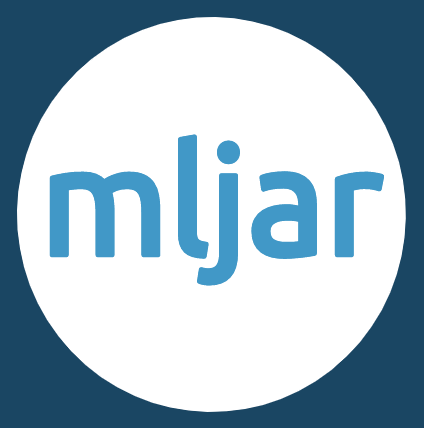

[MLJAR](https://mljar.com) is an automated machine learning tool for tabular data

In [ ]:
!python3 -m pip install -q mljar-supervised
!python3 -m pip install -q -U graphviz

In [ ]:
## import packages
from supervised import AutoML

In [ ]:
## train model
model_mljar = AutoML(
    total_time_limit=MAX_MODEL_RUNTIME_SECS,
    eval_metric='rmse',
    results_path='./mljar'
)

model_mljar.fit(X=train.to_pandas(), y=target)

In [ ]:
## check leaderboard
model_mljar.get_leaderboard()

In [ ]:
## generate predictions
preds_mljar = dt.Frame(model_mljar.predict(test.to_pandas()))

In [ ]:
## create submission
submission = dt.Frame(
    id=test_ids,
    loss=preds_mljar
)

submission.head()

In [ ]:
## save submission
submission.to_csv(PATH_MLJAR_SUBMISSION)

In [ ]:
## clear memory
shutil.rmtree('mljar')

del model_mljar

gc.collect()

This is just a baseline submission over which a lot of improvement can be made. You can read more about MLJAR's workflow, settings, hyperparameters, interpretability and more here:

* [Documentation of MLJAR](https://supervised.mljar.com)

## Similar Tutorials
Similar tutorials on other Kaggle TPS competitions are published here:

* [AutoML Tutorial: TPS (January 2021)](https://www.kaggle.com/rohanrao/automl-tutorial-tps-january-2021)
* [AutoML Tutorial: TPS (February 2021)](https://www.kaggle.com/rohanrao/automl-tutorial-tps-february-2021)
* [AutoML Tutorial: TPS (March 2021)](https://www.kaggle.com/rohanrao/automl-tutorial-tps-march-2021)
* [AutoML Tutorial: TPS (April 2021)](https://www.kaggle.com/rohanrao/automl-tutorial-tps-april-2021)
* [AutoML Tutorial: TPS (May 2021)](https://www.kaggle.com/rohanrao/automl-tutorial-tps-may-2021)
* [AutoML Tutorial: TPS (June 2021)](https://www.kaggle.com/rohanrao/automl-tutorial-tps-june-2021)
* [AutoML Tutorial: TPS (July 2021)](https://www.kaggle.com/rohanrao/automl-tutorial-tps-july-2021)